# Introduction

1. [Load Data and PreCheck](#1)
1. [Preparing Data](#2)
1. [Train Test Split](#3)
1. [Implemantation of CNN](#4)
    * [Data Augmentation with Keras API](#5)
    * [Model Implementation](6)
1. [Conclusion](#7)


<a id='1'></a>
# Load Data and PreCheck

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [2]:
# laod data from numpy file
X = np.load('./sign-language-digits-dataset/X.npy')
y = np.load('./sign-language-digits-dataset/Y.npy')


In [3]:
# reshape X
X = X.reshape(-1,64,64,1)

print("X Shape:",X.shape)
print("Y Shape:",y.shape)

X Shape: (2062, 64, 64, 1)
Y Shape: (2062, 10)


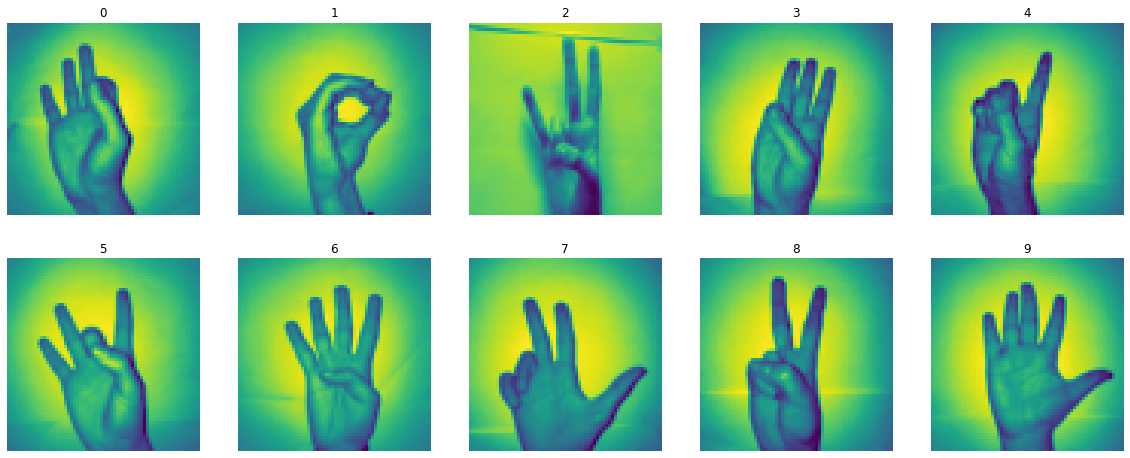

In [4]:
plt.figure(figsize=(20,6))

for i,j in enumerate([0,205,411,617,823,1030,1237,1444,1650,1858]):
    plt.subplot(2,5,i+1)
    plt.subplots_adjust(top = 2, bottom = 1)
    plt.imshow(X[j].reshape(64,64))
    plt.title(np.argmax(y[j]))
    plt.axis('off')


* As you can see, labels and images don't match correctly. So first of all I will re-organize them.
* Image size is 64x64
* There are 2062 images in dataset.

In [5]:
list_y = []
list_y = [np.where(i == 1)[0][0] for i in y]
count = pd.Series(list_y).value_counts()
print(count)

5    208
9    207
3    207
6    207
7    206
8    206
4    206
2    206
1    205
0    204
dtype: int64


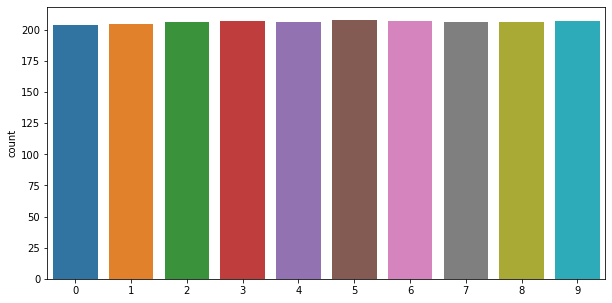

In [6]:
plt.figure(figsize = (10,5))
sns.countplot(np.array(list_y))
plt.show()

* We have a balanced dataset.

<a id='2'></a>
# Preparing Data

I will re-organize data to match labels and images correctly.
* 204-409   => 0
* 822-1028  => 1
* 1649-1855 => 2
* 1443-1649 => 3
* 1236-1443 => 4
* 1855-2062 => 5
* 615-822   => 6
* 409-615   => 7
* 1028-1236 => 8
* 0-204     => 9

In [7]:
X_organized = np.concatenate((X[204:409,:],
                              X[822:1028,:],
                              X[1649:1855,:],
                              X[1443:1649,:],
                              X[1236:1443,:],
                              X[1855:2062,:],
                              X[615:822,:],
                              X[409:615,:],
                              X[1028:1236,:],
                              X[0:204,:]),axis = 0)


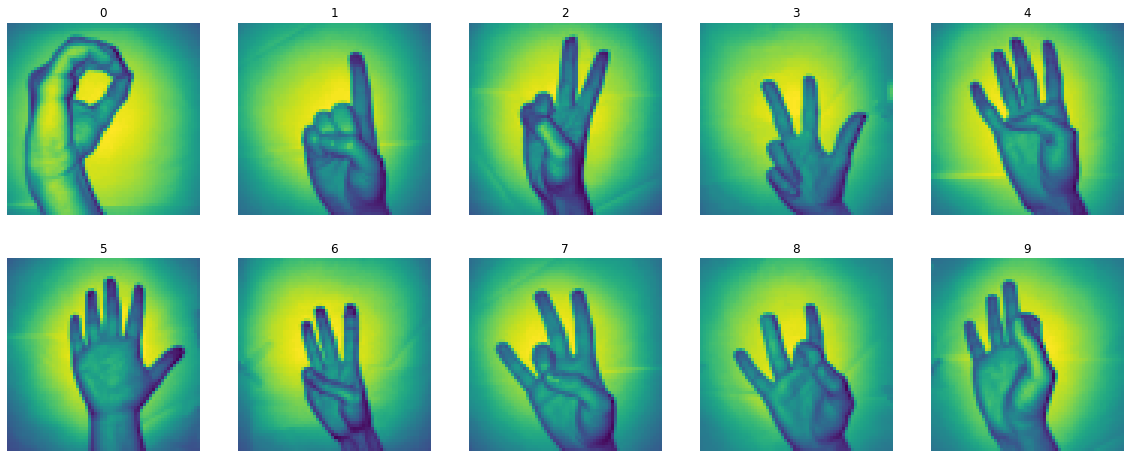

In [8]:
plt.figure(figsize=(20,6))

for i,j in enumerate([0,205,411,617,823,1030,1237,1444,1650,1858]):
    plt.subplot(2,5,i+1)
    plt.subplots_adjust(top = 2, bottom = 1)
    plt.imshow(X_organized[j].reshape(64,64))
    plt.title(np.argmax(y[j]))
    plt.axis('off')

* Now labels and images are matched correctly.

<a id='3'></a>
# Train Test Split

In [9]:
from sklearn.model_selection import train_test_split

x_train,x_test,y_train,y_test = train_test_split(X_organized,y,test_size = 0.2,random_state = 42)

print("x_train shape:",x_train.shape)
print("x_test shape:",x_test.shape)
print("y_train shape:",y_train.shape)
print("y_test shape:",y_test.shape)

x_train shape: (1649, 64, 64, 1)
x_test shape: (413, 64, 64, 1)
y_train shape: (1649, 10)
y_test shape: (413, 10)


* Now our test and train datasets are ready. We can start to create CNN model.

<a id='4'></a>
# Implementation of CNN

<a id='5'></a>
## Data Augmentation With Keras API

Data augmentation is a technique which generates new training samples without changing labels of images. To generate new samples, some features of images are changed like brightness, rotation or zoom level. To apply it, ImageDataGenerator class is used in KERAS API. This class refers parameters and changes images. After complete the changing process, it returns new samples. This is important! ImageDataGenerator returns only new images. It means that out training dataset consists of different from original dataset. It provides more generalizaton for model anf of course it is desirable.

So, in implementation of CNN part, I will use data augmentation and I will change rotation and zoom level of images. I chose these parameters with a simple logic. Think of test data that we might encounter in real life. We don't always hold our hand at 90 degrees. So it is quite possible that we have a rotational change when using sign language. Likewise, the zoom level of the photo to be taken may also change. So I thought I could train my model better by creating a more general data set with these two parameters.  Let's take a closer look at these parameters.

* **rotation_range:** Rotation augmentation randomly rotates the image clockwise by a given number between 0 and 360.
* **zoom_range:** The percentage of the zoom can be a single float or a range as an array or tuple. If a float is specified, then the range for the zoom will be [1-value, 1+value].

I will apply data augmentation with this parameters.
* rotation = 45
* zoom_range = 0.5

Before continue to CNN implementation, let's look some samples to see effects of data augmentation on dataset.

In [10]:
from keras.preprocessing.image import ImageDataGenerator

In [11]:
def show_new_samples(new_images):
    plt.figure(figsize=(20,6))
    for i in range(10):
        plt.subplot(2,5,i+1)
        image = new_images.next()
        plt.imshow(image[0].reshape(64,64))
        plt.axis('off')
    
    plt.show()

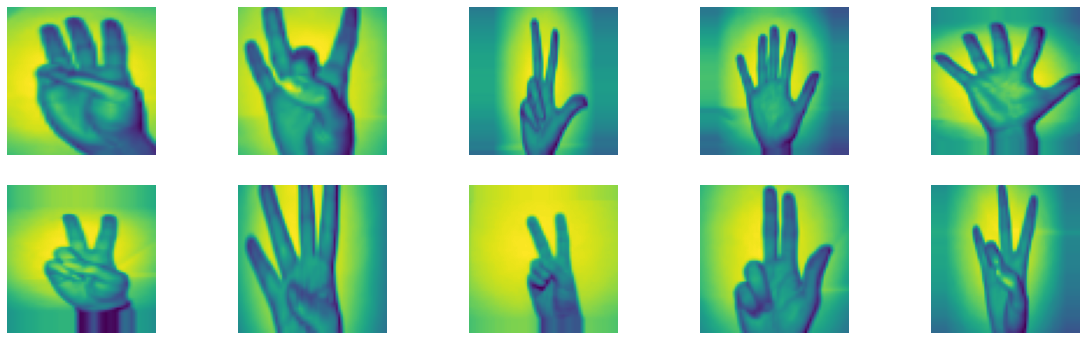

In [12]:
#Changin zoom level
datagen = ImageDataGenerator(zoom_range = 0.5)
new_images = datagen.flow(x_train,batch_size = 250)
show_new_samples(new_images)

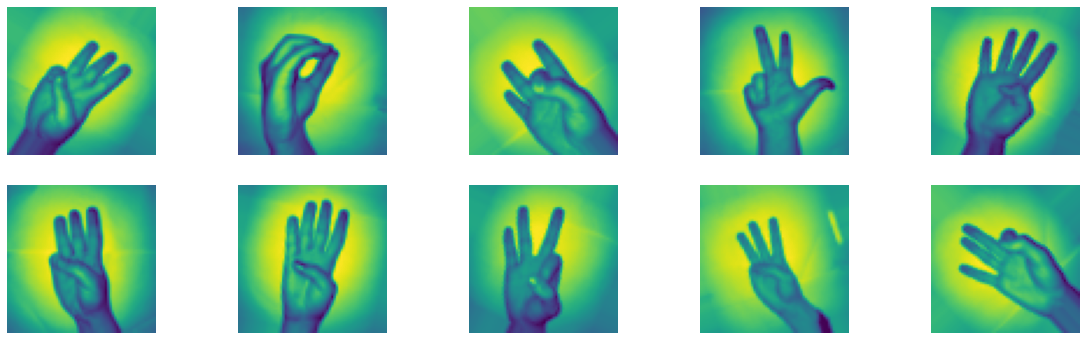

In [13]:
# Changing rotaion 
datagen = ImageDataGenerator(rotation_range = 45)
new_images = datagen.flow(x_train,batch_size = 250)
show_new_samples(new_images)

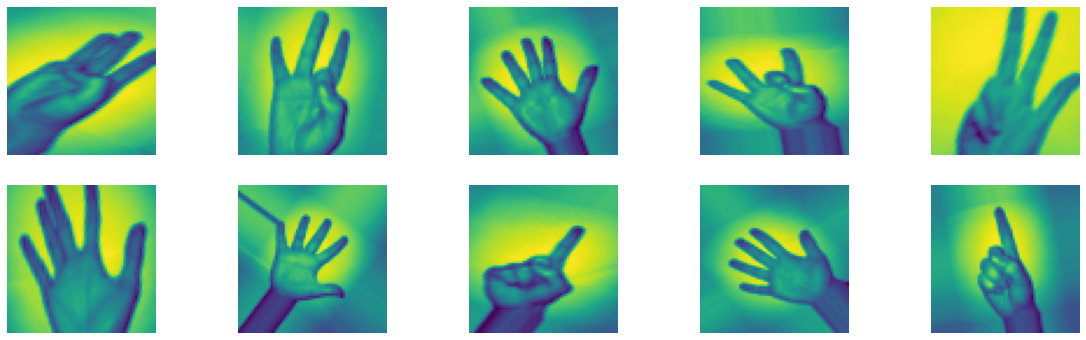

In [14]:
# Changing rotaion, zoom 
datagen = ImageDataGenerator(zoom_range = 0.5,rotation_range = 45)
new_images = datagen.flow(x_train,batch_size = 1)
show_new_samples(new_images)

<a id='6'></a>
## Model Implementation

In [15]:
# load libraries
from keras.models import Sequential
from keras.layers import Dense, Dropout, MaxPool2D, Conv2D, Flatten
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator

In [16]:
model = Sequential()

model.add(Conv2D(filters = 32, kernel_size = (9,9),padding = 'Same', activation ='relu', input_shape = (64,64,1)))
model.add(MaxPool2D(pool_size=(5,5)))
model.add(Dropout(0.2))

model.add(Conv2D(filters = 64, kernel_size = (7,7),padding = 'Same', activation ='relu'))
model.add(MaxPool2D(pool_size=(4,4), strides=(3,3)))
model.add(Dropout(0.2))

model.add(Conv2D(filters = 128 , kernel_size = (5,5),padding = 'Same',activation ='relu'))
model.add(MaxPool2D(pool_size=(3,3), strides=(2,2)))
model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dropout(0.2))
model.add(Dense(256, activation = "relu"))
model.add(Dense(10, activation='softmax'))

optimizer = Adam(lr=0.001, beta_1=0.9, beta_2=0.999)

model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])

datagen = ImageDataGenerator(zoom_range = 0.5,rotation_range = 45)
datagen.fit(x_train)

history = model.fit(datagen.flow(x_train,y_train, batch_size=250),epochs = 100, validation_data = (x_test,y_test))

Epoch 1/100
7/7 [==============================] - 7s 945ms/step - loss: 2.3086 - accuracy: 0.0946 - val_loss: 2.3035 - val_accuracy: 0.0775
Epoch 2/100
7/7 [==============================] - 6s 897ms/step - loss: 2.3025 - accuracy: 0.1025 - val_loss: 2.3044 - val_accuracy: 0.0775
Epoch 3/100
7/7 [==============================] - 7s 988ms/step - loss: 2.3029 - accuracy: 0.1043 - val_loss: 2.3059 - val_accuracy: 0.0775
Epoch 4/100
7/7 [==============================] - 7s 960ms/step - loss: 2.3033 - accuracy: 0.1031 - val_loss: 2.3036 - val_accuracy: 0.0775
Epoch 5/100
7/7 [==============================] - 6s 900ms/step - loss: 2.3022 - accuracy: 0.1061 - val_loss: 2.3042 - val_accuracy: 0.0775
Epoch 6/100
7/7 [==============================] - 7s 1s/step - loss: 2.3011 - accuracy: 0.1031 - val_loss: 2.3038 - val_accuracy: 0.0847
Epoch 7/100
7/7 [==============================] - 7s 992ms/step - loss: 2.3000 - accuracy: 0.1098 - val_loss: 2.3033 - val_accuracy: 0.1017
Epoch 8/100
7/7 

<a id='7'></a>
# Conclusion

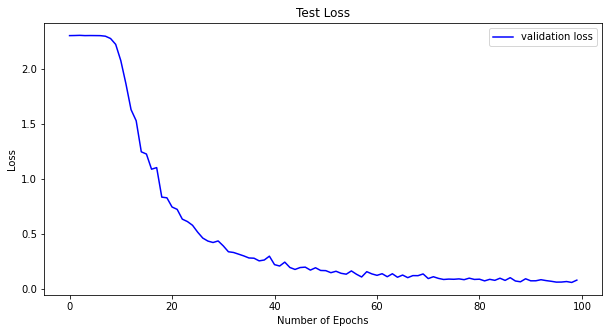

In [17]:
plt.figure(figsize = (10,5))
plt.plot(history.history['val_loss'], color='b', label="validation loss")
plt.title("Test Loss")
plt.xlabel("Number of Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

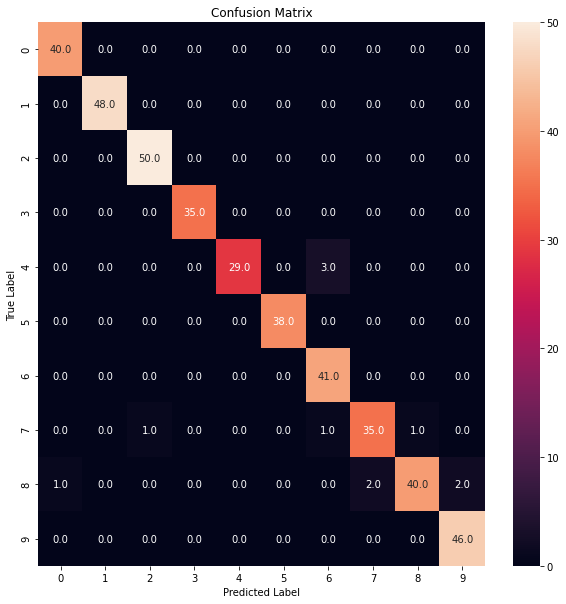

In [18]:
y_predict = model.predict(x_test)
y_predict_classes = np.argmax(y_predict,axis = 1) 
y_true = np.argmax(y_test,axis = 1) 
confusion_mtx = confusion_matrix(y_true, y_predict_classes) 
plt.figure(figsize = (10,10))
sns.heatmap(confusion_mtx, annot=True,fmt= '.1f')
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()